In [543]:
'''MPC WITH A SIMPLIFIED STATE SPACE MODEL FOR DEBUGGING / LEARNING PURPOSES'''
# import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sp
from sympy.utilities.lambdify import lambdify
from matplotlib import rcParams
import casadi as ca
import do_mpc

In [544]:
# Helpers

# Inertia Tensors (numeric, gimbals unused)
I = np.matrix([[1.0, 0.0, 0.0],
               [0.0, 1.0, 0.0],
               [0.0, 0.0, 1.0]])
I_s = np.matrix([[1.0, 0.0, 0.0],
               [0.0, 1.0, 0.0],
               [0.0, 0.0, 1.0]])
I_a = np.matrix([[0.5, 0.0, 0.0],
               [0.0, 0.5, 0.0],
               [0.0, 0.0, 0.5]])
I_b = np.matrix([[0.5, 0.0, 0.0],
               [0.0, 0.5, 0.0],
               [0.0, 0.0, 0.5]])

# COP / COT / COM Offsets (numeric, currently unused)
rc = np.array([0.0, 0.0, 0.1])  # cop offset
rt = np.array([0.0, 0.0, -0.1])  # cot offset
r_rcs = 0.05  # rcs offset


In [545]:
# Build state space model
# currently 3DOF, making it 6DOF.

# define numeric variables (adjust as needed)
g = 9.81  # gravity
m = 1.0  # mass, constant for now.
rho = 1.225  # air density
A = 0.1  # cross-sectional area
C_d = 0.5  # drag coefficient
# A and cD assumed to be constant for simplicity

# define equations of motion
# x_d = f(x,u), where f is some nonlinear function. 
# state is defined as z, the altitude and z_dot, the vertical velocity
model = do_mpc.model.Model('continuous')

# Linear states
r = model.set_variable('_x', 'r', shape=(3,1))
r_dot = model.set_variable('_x', 'r_dot', shape=(3,1))
# Angular states
omega = model.set_variable('_x', 'omega', shape=(3,1))
omega_dot = model.set_variable('_x', 'omega_dot', shape=(3,1))
T = model.set_variable('_u', 'T')
a = model.set_variable('_u', 'a')
b = model.set_variable('_u', 'b')
R1 = model.set_variable('_u', 'R1') # clockwise - positive, only one direction
R2 = model.set_variable('_u', 'R2') # counterclockwise - negative, only one direction

# Rotational Motion
# first, create rotation matrices from euler angles
cphi, sphi   = ca.cos(omega[0]),   ca.sin(omega[0]) # roll
cth,  sth    = ca.cos(omega[1]), ca.sin(omega[1]) # pitch
cpsi, spsi   = ca.cos(omega[2]),   ca.sin(omega[2]) # yaw

R_z = ca.blockcat([[ cphi, -sphi, 0],
                   [ sphi,  cphi, 0],
                   [    0,     0, 1]])

R_y = ca.blockcat([[ cth, 0, sth],
                   [   0, 1,   0],
                   [-sth, 0, cth]])

R_x = ca.blockcat([[1, 0,    0],
                   [0, cpsi, -spsi],
                   [0, spsi,  cpsi]])

R_bf = ca.mtimes(R_z, R_y)
R_bf = ca.mtimes(R_bf, R_x)
R_wf = R_bf.T



# first, calculate torques in body.
# Drag force needs velocity in the body frame. Alternatively, can transform from world frame.
F_d_wf = ca.vertcat(
    -0.5*rho*A*C_d*(ca.fabs(r_dot[0]))*r_dot[0],
    -0.5*rho*A*C_d*(ca.fabs(r_dot[1]))*r_dot[1],
    -0.5*rho*A*C_d*(ca.fabs(r_dot[2]))*r_dot[2]
)
F_d_bf = ca.mtimes(R_bf, F_d_wf)

F_t_bf = ca.vertcat(
    T*ca.cos(b)*ca.sin(a),
    T*ca.sin(a),
    T*ca.cos(b)*ca.cos(a)
)

F_g_wf = ca.vertcat(
    0,
    0,
    -m*g
)
F_g_bf = ca.mtimes(R_wf, F_g_wf) 

# Net force and linear in body frame
F_net_bf = F_t_bf + F_d_bf + F_g_bf

# Acceleration in world frame
F_net_wf = ca.mtimes(R_wf, F_net_bf)
rhs_r_dot = ca.mtimes(1/m, F_net_wf)

# Net torque in body frame
tau_d_bf = ca.cross(rc, F_d_bf)
tau_t_bf = ca.cross(rt, F_t_bf)
tau_rcs_bf = r_rcs*(R1 - R2)
tau_net_bf = tau_d_bf + tau_t_bf + tau_rcs_bf
# Net torque in world frame
tau_net_wf = ca.mtimes(R_wf, tau_net_bf)
I_wf = ca.mtimes(R_wf, I)
I_wf = ca.mtimes(I_wf, R_wf.T)
I_wf_inv = ca.inv(I_wf)

# angular acceleration in world frame
rhs_omega_dot = ca.mtimes(I_wf_inv, tau_net_wf)

#Translational Velocity
rhs_r = ca.vertcat(
    r_dot[0],                                                            # ẋ = v_x
    r_dot[1],                                                            # ẏ = v_y
    r_dot[2],                                                            # ż = v_z
)

# Rotational Velocity
rhs_omega = ca.vertcat(
    omega[0],                                                            # φ̇ = ω_x
    omega[1],                                                            # θ̇ = ω_y
    omega[2],                                                            # ψ̇ = ω_z
)

# revise these equations with rotational motion.
# rhs_r_dot = ca.vertcat(
#     (1/m)*(T*ca.cos(b)*ca.sin(a) - 0.5*rho*A*C_d*(ca.fabs(r_dot[0]))*r_dot[0]),
#     (1/m)*(T*ca.sin(a)           - 0.5*rho*A*C_d*(ca.fabs(r_dot[1]))*r_dot[1]),
#     (1/m)*(T*ca.cos(b)*ca.cos(a) - m*g - 0.5*rho*A*C_d*(ca.fabs(r_dot[2]))*r_dot[2])
# )


model.set_rhs('r', rhs_r)
model.set_rhs('r_dot', rhs_r_dot)
model.set_rhs('omega', rhs_omega)
model.set_rhs('omega_dot', rhs_omega_dot)

model.setup()

In [546]:
# Configuring controller
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    # automatically discretized with collocation
    'n_horizon': 5,
    't_step': 0.1,
    'n_robust': 1, # default to 0 if not specified
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [547]:
# Cost Function. Will be defined as a quadratic function
# error between desired and actual state as well as control effort.
x_ref = 2.0  # desired x position
x_dot_ref = 0.0  # desired x velocity
y_ref = 2.0  # desired y position
y_dot_ref = 0.0  # desired y velocity
z_ref = 5.0  # desired altitude
z_dot_ref = 0.0  # desired vertical velocity

phi_ref = 0.0  # desired roll angle
theta_ref = 0.0  # desired pitch angle
psi_ref = 0.0  # desired yaw angle
phi_dot_ref = 0.0  # desired roll rate
theta_dot_ref = 0.0  # desired pitch rate
psi_dot_ref = 0.0  # desired yaw rate

dx = r[0] - x_ref
dx_dot = r_dot[0] - x_dot_ref
dy = r[1] - y_ref
dy_dot = r_dot[1] - y_dot_ref
dz = r[2] - z_ref
dz_dot = r_dot[2] - z_dot_ref

dphi = omega[0] - phi_ref
dphi_dot = omega_dot[0] - phi_dot_ref
dtheta = omega[1] - theta_ref
dtheta_dot = omega_dot[1] - theta_dot_ref
dpsi = omega[2] - psi_ref
dpsi_dot = omega_dot[2] - psi_dot_ref

err_vec = ca.vertcat(
    dx,
    dx_dot,
    dy,
    dy_dot,
    dz,
    dz_dot,
    dphi,
    dphi_dot,
    dtheta,
    dtheta_dot,
    dpsi,
    dpsi_dot
)
# Cost matrix
Q = np.diag([1.0, 1.0, 2.0, # xyz position state penalty
             0.75, 0.75, 2.0, # xyz velocity state penalty
             3.0, 2.0, 2.0, # roll, pitch, yaw angle penalty
             3.0, 2.0, 2.0 # roll, pitch, yaw rate penalty
             ])

# m_term is mayer term and l_term is lagrange term. 
# TODO: figure out what these are.
m_term = ca.mtimes(err_vec.T, Q)  # quadratic term
m_term = ca.mtimes(m_term, err_vec)  # quadratic term
l_term = m_term

mpc.set_objective(mterm=m_term, lterm=l_term)
mpc.set_rterm(T=0.01, a=0.01, b=0.01, R1 = 0.01, R2 = 0.01)  # control effort penalty

mpc.bounds['lower', '_x', 'r'] = -np.inf
mpc.bounds['upper', '_x','r'] = np.inf
mpc.bounds['lower', '_x', 'r_dot'] = -np.inf
mpc.bounds['upper', '_x', 'r_dot'] = np.inf
mpc.bounds['lower', '_x', 'omega'] = -np.inf
mpc.bounds['upper', '_x', 'omega'] = np.inf
mpc.bounds['lower', '_x', 'omega_dot'] = -np.inf
mpc.bounds['upper', '_x', 'omega_dot'] = np.inf
mpc.bounds['lower', '_u', 'a'] = -np.pi/12  # gimbal angle cannot be too low
mpc.bounds['upper', '_u', 'a'] = np.pi/12  # gimbal angle cannot be too high
mpc.bounds['lower', '_u', 'b'] = -np.pi/12  # gimbal angle cannot be too low
mpc.bounds['upper', '_u', 'b'] = np.pi/12  # gimbal angle cannot be too high
mpc.bounds['upper', '_u', 'T'] = 15.0  # thrust cannot be too high
mpc.bounds['lower', '_u', 'T'] = 0.0  # thrust cannot be negative
mpc.bounds['lower', '_u', 'R1'] = 0  # rcs cannot be negative
mpc.bounds['upper', '_u', 'R1'] = 1  # max rcs1 thrust
mpc.bounds['lower', '_u', 'R2'] = 0  # rcs cannot be negative
mpc.bounds['upper', '_u', 'R2'] = 1  # max rcs2 thrust

# Scaling can be done, will not be done here because I don't know how it works or if its needed.
mpc.setup()


In [548]:
# Configure built-in simulator.
simulator = do_mpc.simulator.Simulator(model)

simulator.set_param(t_step = 0.1)

simulator.setup()

In [549]:
# Initialize and start control loop
x0 = np.array([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])  # initial state
mpc.x0 = x0
mpc.set_initial_guess()
simulator.x0 = x0

In [550]:
# Run simulation
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.figsize'] = (14, 12)   # width, height in inches
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.loc'] = 'best'

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [551]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(5, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [552]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the state variables on the first axis:
    g.add_line(var_type='_x', var_name='r', axis=ax[0])
    g.add_line(var_type='_x', var_name='r_dot', axis=ax[1])
    g.add_line(var_type='_x', var_name='omega', axis=ax[2])
    g.add_line(var_type='_x', var_name='omega_dot', axis=ax[3])

    # Plot the control outputs on the second axis:
    g.add_line(var_type='_u', var_name='T', axis=ax[4])
    g.add_line(var_type='_u', var_name='R1', axis=ax[4])
    g.add_line(var_type='_u', var_name='R2', axis=ax[4])

ax[0].set_ylabel('position[m]')
ax[1].set_ylabel('velocity[m/s]')
ax[2].set_ylabel('e-ang[rad]')
ax[3].set_ylabel('ang-vel[rad/s]')
ax[4].set_ylabel('control [N/rad]')

ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')
ax[2].set_xlabel('time [s]')
ax[3].set_xlabel('time [s]')
ax[4].set_xlabel('time [s]')

In [553]:
# run simulator without any control. This is to see if what we've done so far is correct,
# both in terms of code logic and the state space model itself.

u0 = np.zeros((5,1))
for i in range(200):
    simulator.make_step(u0)

In [554]:
# sim_graphics.plot_results()
# # Reset the limits on all axes in graphic to show the data.
# sim_graphics.reset_axes()

# # add info to the plot
# pos_labels = ['x_pos', 'y_pos', 'z_pos']
# vel_labels = ['x_dot', 'y_dot', 'z_dot']
# omega_labels = ['roll', 'pitch', 'yaw']
# omega_dot_labels = ['roll_dot', 'pitch_dot', 'yaw_dot']

# pos_lines = sim_graphics.result_lines['_x','r']
# vel_lines = sim_graphics.result_lines['_x','r_dot']
# omega_lines = sim_graphics.result_lines['_x','omega']
# omega_dot_lines = sim_graphics.result_lines['_x','omega_dot']
# control_lines = sim_graphics.result_lines['_u', 'T']+sim_graphics.result_lines['_u', 'R1']+sim_graphics.result_lines['_u', 'R2']

# ax[0].legend(pos_lines, 'xyz', title='position')

# # also set legend for second subplot:
# ax[1].legend(vel_lines, vel_labels,title='velocity')

# ax[2].legend(omega_lines, omega_labels, title='euler angles')

# ax[3].legend(omega_dot_lines, omega_dot_labels, title='angular velocity')
# ax[4].legend(control_lines, ['T', 'R1', 'R2'], title='control inputs')
# # Show the figure:
# fig

# # simulator.reset_history()
# # simulator.x0 = x0
# # mpc.reset_history()

In [555]:
# Once verified, we can run the actual control loop.

simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()


In [556]:
%%capture
for i in range(200):
    print('step', i)
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

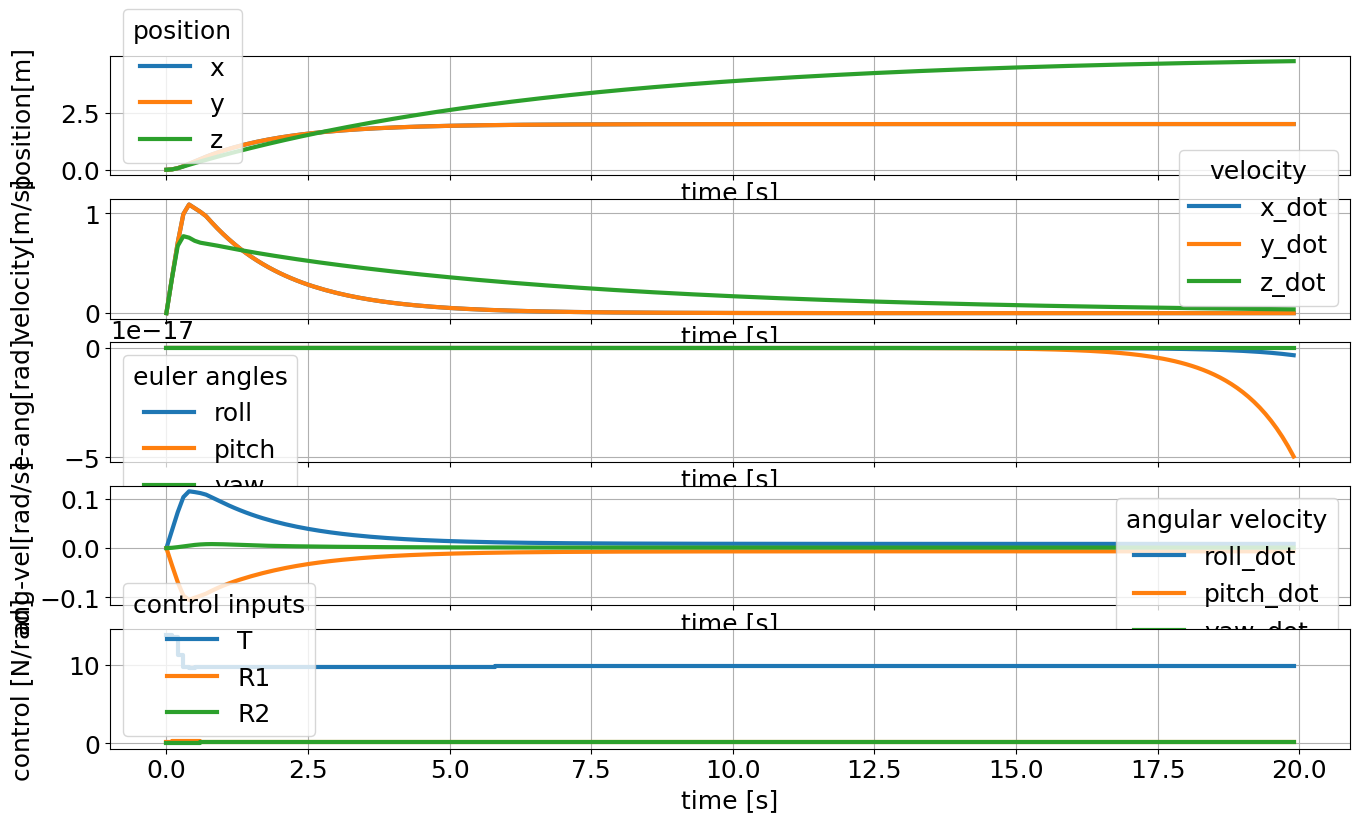

In [557]:
# Plot results until current time
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()

# add info to the plot
pos_labels = ['x_pos', 'y_pos', 'z_pos']
vel_labels = ['x_dot', 'y_dot', 'z_dot']
omega_labels = ['roll', 'pitch', 'yaw']
omega_dot_labels = ['roll_dot', 'pitch_dot', 'yaw_dot']

pos_lines = sim_graphics.result_lines['_x','r']
vel_lines = sim_graphics.result_lines['_x','r_dot']
omega_lines = sim_graphics.result_lines['_x','omega']
omega_dot_lines = sim_graphics.result_lines['_x','omega_dot']
control_lines = sim_graphics.result_lines['_u', 'T']+sim_graphics.result_lines['_u', 'R1']+sim_graphics.result_lines['_u', 'R2']

ax[0].legend(pos_lines, 'xyz', title='position')

# also set legend for second subplot:
ax[1].legend(vel_lines, vel_labels,title='velocity')

ax[2].legend(omega_lines, omega_labels, title='euler angles')

ax[3].legend(omega_dot_lines, omega_dot_labels, title='angular velocity')
ax[4].legend(control_lines, ['T', 'R1', 'R2'], title='control inputs')
# Show the figure:
fig